In [1]:
import pandas as pd
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
# Hinged Square Loss
class SquaredHingeLoss(nn.Module):
    def __init__(self, margin=1):
        super(SquaredHingeLoss, self).__init__()
        self.margin = margin

    def forward(self, predicted, y):
        low, high = y[:, 0:1], y[:, 1:2]
        loss_low = torch.relu(low - predicted + self.margin)
        loss_high = torch.relu(predicted - high + self.margin)
        loss = loss_low + loss_high
        return torch.mean(torch.square(loss))

In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, layers_size):
        super(SimpleNN, self).__init__()
        self.layers = nn.ModuleList()  # Initialize an empty list for layers
        
        # Add the first layer from input_size to the first hidden layer size
        self.layers.append(nn.Linear(input_size, layers_size[0]))

        # Add the rest of the hidden layers
        for i in range(1, len(layers_size)):
            self.layers.append(nn.Linear(layers_size[i-1], layers_size[i]))

        # Add the output layer (from last hidden layer to output size 1)
        self.output_layer = nn.Linear(layers_size[-1], 1)
        
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        # Pass input through hidden layers
        for layer in self.layers:
            x = self.leaky_relu(layer(x))
        
        # Pass through the final output layer
        x = self.output_layer(x)

        # Apply the activation function: 7 * tanh(x)
        x = 7 * torch.tanh(x)
        return x

In [4]:
class ModelTrainer:
    def __init__(self, dataset, chosen_feature, test_fold, input_size, layer_size):
        self.dataset = dataset
        self.chosen_feature = chosen_feature
        self.test_fold = test_fold
        self.input_size = input_size
        self.layer_size = layer_size
        self.SimpleNN = SimpleNN
        self.load_data()
        self.prepare_data()
        self.initialize_model()

    def load_data(self):
        self.folds_df = pd.read_csv(f'../../training_data/{self.dataset}/folds.csv')
        self.features_df = pd.read_csv(f'../../training_data/{self.dataset}/features.csv')[['sequenceID'] + self.chosen_feature]
        self.target_df = pd.read_csv(f'../../training_data/{self.dataset}/target.csv')
    
    def prepare_data(self):
        train_ids = self.folds_df[self.folds_df['fold'] != self.test_fold]['sequenceID']
        test_ids = self.folds_df[self.folds_df['fold'] == self.test_fold]['sequenceID']

        self.features_df_train = self.features_df[self.features_df['sequenceID'].isin(train_ids)]
        self.features_df_test = self.features_df[self.features_df['sequenceID'].isin(test_ids)]
        self.target_df_train = self.target_df[self.target_df['sequenceID'].isin(train_ids)]
        self.target_df_test = self.target_df[self.target_df['sequenceID'].isin(test_ids)]

        self.X_train = self.features_df_train[self.chosen_feature].to_numpy()
        self.y_train = self.target_df_train.iloc[:, 1:].to_numpy()
        self.X_test = self.features_df_test[self.chosen_feature].to_numpy()
        self.y_test = self.target_df_test.iloc[:, 1:].to_numpy()

        self.X_train_tensor = torch.tensor(self.X_train, dtype=torch.float32)
        self.y_train_tensor = torch.tensor(self.y_train, dtype=torch.float32)
        self.X_test_tensor = torch.tensor(self.X_test, dtype=torch.float32)
        self.y_test_tensor = torch.tensor(self.y_test, dtype=torch.float32)

    def initialize_model(self):
        self.input_dim = self.X_train.shape[1]
        self.model = self.SimpleNN(self.input_dim, self.layer_size)
        self.criterion = SquaredHingeLoss()
        self.optimizer = optim.Adam(self.model.parameters())

    def train(self, epochs=1000000, patience=1000):
        best_train_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            self.model.train()
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(self.X_train_tensor)
            loss = self.criterion(outputs, self.y_train_tensor)

            # Backward pass and optimization
            loss.backward()
            self.optimizer.step()

            # Early stopping check
            train_loss = loss.item()
            if train_loss < best_train_loss:
                best_train_loss = train_loss
                self.best_model = self.model.state_dict()  # Save the best model state
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

        # Load the best model
        self.model.load_state_dict(self.best_model)

    def predict(self):
        self.model.eval()
        self.y_pred = self.model(self.X_test_tensor).detach().numpy().ravel()

    def plot_results(self):
        x = self.X_test_tensor.numpy()
        y_low = self.y_test_tensor.numpy()[:, 0]
        y_high = self.y_test_tensor.numpy()[:, 1]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Scatter plot for x vs y_low and x vs y_high
        ax.scatter(x, y_low, color='blue', edgecolor='black', marker='o', label='y_low', facecolors='none', s=15)
        ax.scatter(x, y_high, color='red', marker='o', label='y_high', s=15)

        # Draw vertical lines from y_low to y_high
        for xi, yi_low, yi_high in zip(x, y_low, y_high):
            ax.plot([xi, xi], [yi_low, yi_high], color='gray', linestyle='--')

        # Draw piecewise line for x vs y_pred
        x_model = np.linspace(x.min(), x.max(), 1000).reshape(-1, 1)
        y_model = self.model(torch.tensor(x_model, dtype=torch.float32)).detach().numpy().ravel()
        ax.plot(x_model, y_model, color='black', label='y_pred', linestyle='-', linewidth=1)

        # Add labels and legend
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()

        # Calculate the loss for the test set
        y_pred_test = self.model(self.X_test_tensor)
        test_loss = self.criterion(y_pred_test, self.y_test_tensor).item()

        # Display the loss in the bottom-right corner of the plot
        ax.text(0.95, 0.05, f'Loss: {test_loss:.4f}', transform=ax.transAxes, 
                fontsize=12, verticalalignment='bottom', horizontalalignment='right', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        # Show the plot
        plt.show()

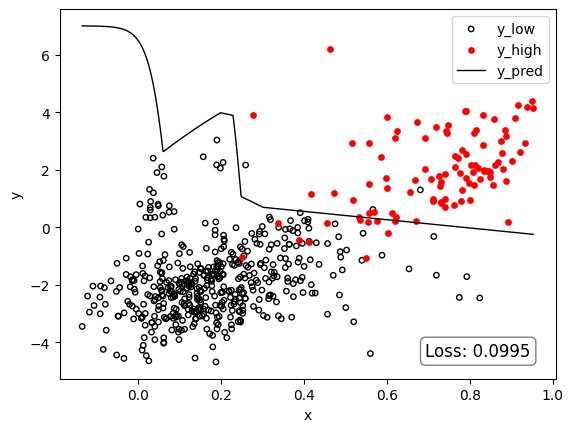

In [5]:
trainer = ModelTrainer(
    dataset='systematic',
    chosen_feature=['autocorr'],
    test_fold=1,
    input_size=1,
    layer_size=[4,4]
)

trainer.train()
trainer.predict()
trainer.plot_results()

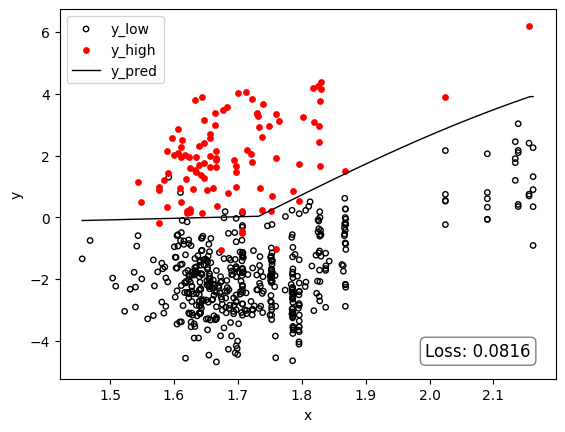

In [7]:
trainer = ModelTrainer(
    dataset='systematic',
    chosen_feature=['loglog_count'],
    test_fold=1,
    input_size=1,
    layer_size=[4,4]
)

trainer.train()
trainer.predict()
trainer.plot_results()

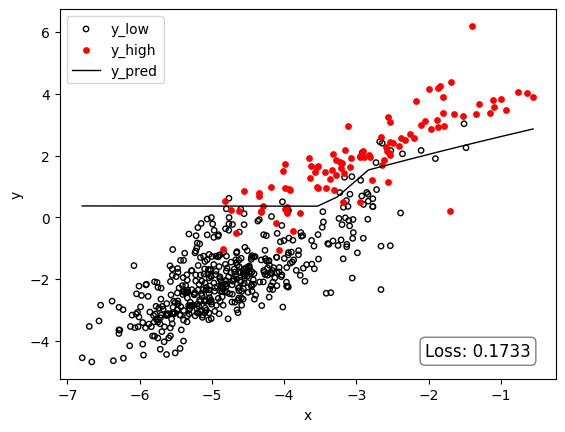

In [8]:
trainer = ModelTrainer(
    dataset='systematic',
    chosen_feature=['log_variance'],
    test_fold=1,
    input_size=1,
    layer_size=[4,4]
)

trainer.train()
trainer.predict()
trainer.plot_results()

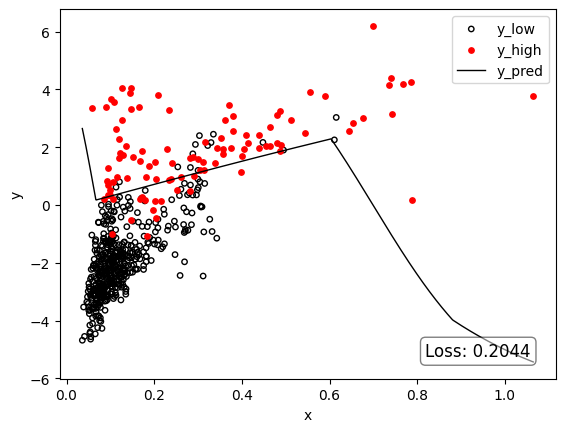

In [9]:
trainer = ModelTrainer(
    dataset='systematic',
    chosen_feature=['iqr'],
    test_fold=1,
    input_size=1,
    layer_size=[4,4]
)

trainer.train()
trainer.predict()
trainer.plot_results()

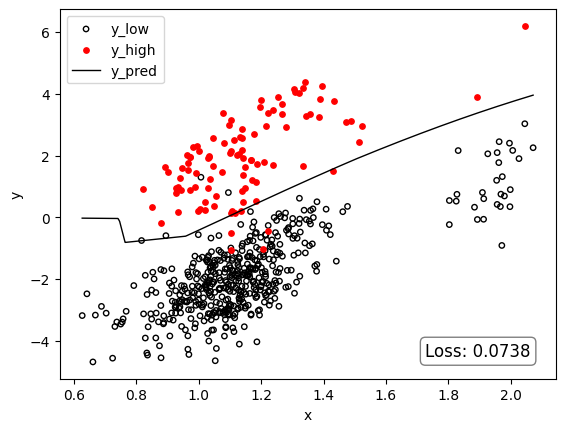

In [10]:
trainer = ModelTrainer(
    dataset='systematic',
    chosen_feature=['loglog_sum_diff'],
    test_fold=1,
    input_size=1,
    layer_size=[4,4]
)

trainer.train()
trainer.predict()
trainer.plot_results()

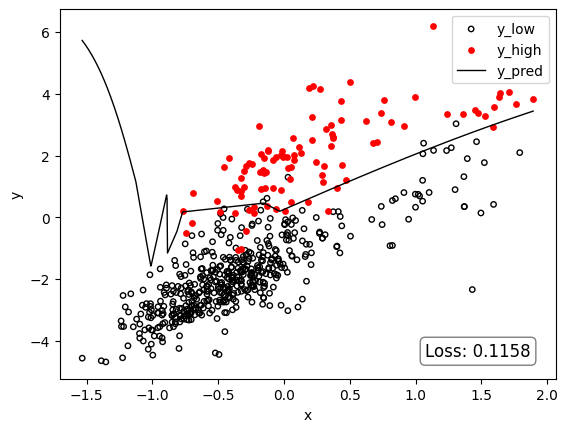

In [11]:
trainer = ModelTrainer(
    dataset='systematic',
    chosen_feature=['log_range_value'],
    test_fold=1,
    input_size=1,
    layer_size=[4,4]
)

trainer.train()
trainer.predict()
trainer.plot_results()

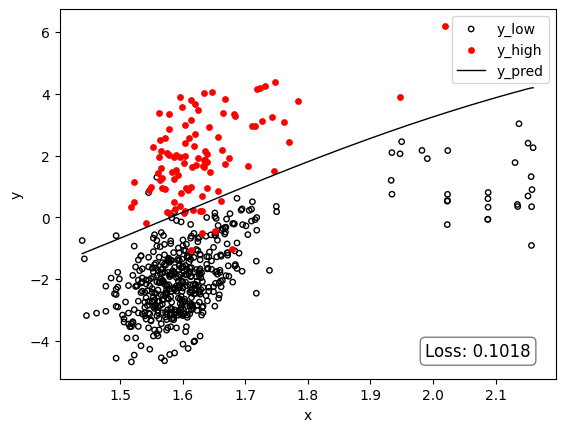

In [12]:
trainer = ModelTrainer(
    dataset='systematic',
    chosen_feature=['loglog_unique_count'],
    test_fold=1,
    input_size=1,
    layer_size=[4,4]
)

trainer.train()
trainer.predict()
trainer.plot_results()